#General Info

Trevor Winger <br/>
University of Minnesota<br/>
CSCI 5751 - Big Data Engineering<br/>
Chad Dvoracek

##Data Details

Data came from one source: 
<ul>
  <li>New York Times; the data is availble from their GitHub [here](https://github.com/nytimes/covid-19-data).</li>
</ul>

##Description of Notebook

<ul>
  <li>Python library imports</li>
  <li>Download data from s3 to pyspark dfs</li>
  <li>Clean and validate data</li>
  <li>Data wrangling </li>
  <li>Statistical Analysis</li>
  <li>Visualization</li>
  <li>Prep for Machine Learning</li>
  <li>Machine Learning Model Development</li>
  <li>Machine Learning Results</li>
  <li>Learned Feature Visualization</li>
</ul>

#Python Libraries

In [0]:
import pandas as pd
from pyspark.sql.functions import approx_count_distinct, avg, stddev, sum, max, min, lit


#sklearn specific
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Data Importing

In [0]:
#set this to true if you want to see the .show(n=10) for each df, else set to False. 
#Useful to see interediate transactions for testing, in production it will significantly slow down notebook
logging = False

##Helper Functions

In [0]:
def log_df(df):
    if logging:
        #use the pandas because it looks better
        df.toPandas().head(10)

In [0]:
def s3_to_df(file_name):
    '''
    Helper function for taking s3 file, and making it a pyspark dataframe
    Infer schema so I can demonstrate some cleaning functionality in other cells
    '''
    df = spark.read.format('csv').options(header='true', inferSchema='true').load(file_name)
    log_df(df)
    return df

##New York Times Data

In [0]:
#state level data
state_df = s3_to_df('s3://winge159project3/us-states.csv')

#append county data on fps
counties_2020 = s3_to_df('s3://winge159project3/us-counties-2020.csv')
counties_2021 = s3_to_df('s3://winge159project3/us-counties-2021.csv')
counties_2022 = s3_to_df('s3://winge159project3/us-counties-2022.csv')
county_df = counties_2020.union(counties_2021)
county_df = county_df.union(counties_2022)

#mask usage
mask_df = s3_to_df('s3://winge159project3/mask-use/mask-use-by-county.csv')

#college data
col_df = s3_to_df('s3://winge159project3/colleges/colleges.csv')

#correctional facilities
facilities_df = s3_to_df('s3://winge159project3/prisons/facilities.csv')

#Clean & Validate Data

##Data Prep

In [0]:
#select certain features from the covid project data, we do not need all of them for this analysis`
s_x_d_df = state_x_day_df.select(state_x_day_df.date, state_x_day_df.state, state_x_day_df.positive, state_x_day_df.negative,  state_x_day_df.probableCases, state_x_day_df.fips, state_x_day_df.death, state_x_day_df.hospitalized, state_x_day_df.total )
log_df(s_x_d_df)

In [0]:
#rename columns in ny times data to not be duplicates
state_df = state_df.withColumnRenamed('cases', 'state_cases')
state_df = state_df.withColumnRenamed('deaths', 'state_deaths')

county_df = county_df.withColumnRenamed('cases', 'county_cases')
county_df = county_df.withColumnRenamed('deaths', 'county_deaths')

col_df = col_df.withColumnRenamed('cases', 'college_cases')


#Data Wrangling & Conditioning

##Joins

In [0]:
#mask need to inner join with a set of mn_county_df to get masks 
distinct_counties = county_df.select('fips').distinct()
masks_df = mask_df.join(distinct_counties, distinct_counties.fips == mask_df.COUNTYFP, 'inner')
masks_df = masks_df.drop('COUNTYFP')


#create a state by x dfs of new york times data for each date with each longitudinal dataset
county_df = county_df.join(masks_df, ['fips'])

state_x_county_df = state_df.join(county_df, ['state', 'date'], 'inner')
state_x_college_df = state_df.join(col_df, ['state', 'date'], 'inner')


#join mask sentiment with our state by county df
#state_x_county_df = state_x_county_df.join(masks_df, ['fips'])
log_df(state_x_county_df)
log_df(masks_df)

##Aggregation & Validation

###College Aggregation Analysis

In [0]:
#state x college level analysis
def agg_stats_college(df):
    print('*'*100)
    #have to select distinct colleges 
    print('total # of cases in college', df.select(sum(df.college_cases)).collect()[0][0])
    print('percent of cases in college', round(df.select(sum(df.college_cases)).collect()[0][0]/ df.select(max(df.state_cases)).collect()[0][0], 4)* 100, '%')
    print('total colleges measured', df.select(approx_count_distinct(df.college)).collect()[0][0])
    print('average cases each day reported for colleges', df.select(avg(df.college_cases)).collect()[0][0])
    print('range in cases each day for colleges', df.select(max(df.college_cases)-min(df.college_cases)).collect()[0][0])
    print('*'*100)

In [0]:
if logging:
    #run on entire country dataset
    agg_stats_college(state_x_college_df)

    #run on just MN
    agg_stats_college(state_x_college_df.filter(state_x_college_df.state == 'Minnesota'))

In [0]:
if logging:
    #run this computation for every state in system
    for s in state_x_college_df.select(state_x_college_df.state).distinct().collect():
        print(s.state)
        agg_stats_college(state_x_college_df.filter(state_x_college_df.state == s.state))



###County Aggregation Analysis

In [0]:
def agg_county(df):
    print('*'*100)
    print('total # of cases in county', df.select(max(df.county_cases)).collect()[0][0])
    print('total recorded # cases in state(s)', df.select(max(df.state_cases)).collect()[0][0])
    print('percent of cases in county', round(df.select(max(df.county_cases)).collect()[0][0]/ df.select(max(df.state_cases)).collect()[0][0], 4)* 100, '%')
    print('average cases each day reported for county', df.select(avg(df.county_cases)).collect()[0][0])
    print('average cases each day reported for state', df.select(avg(df.state_cases)).collect()[0][0])
    print('standard deviation in cases each day for county', df.select(stddev(df.county_cases)).collect()[0][0])
    print('standard deviation in cases each day for state(s)', df.select(stddev(df.state_cases)).collect()[0][0])
    print('*'*100)

In [0]:
if logging:
    #this could be computer on a county x state level for each state; however for free tier limitations I will only demonstrate it on Minnesota counties
    for c in state_x_county_df.filter(state_x_county_df.state == 'Minnesota').select(state_x_county_df.county).distinct().collect():
        print(c.county)
        agg_county(state_x_county_df.filter(state_x_county_df.county == c.county))

##Created Functions

In [0]:

def county_lambda(x):
    #perform some computations on our dataset; will be passes a single row and return new row for our transformed df
    date = x.date
    state = x.state
    county = x.county
    percent_at_day_c = x.county_cases / x.state_cases
    percent_at_day_d = 0
    if x.state_deaths != 0:
        percent_at_day_d = x.county_deaths / x.state_deaths
    n = x.NEVER
    r = x.RARELY
    s = x.SOMETIMES
    f = x.FREQUENTLY
    a = x.ALWAYS
    
    return (date, state, county, percent_at_day_c, percent_at_day_d, n, r, s, f, a)

In [0]:
def college_lambda(x):
    #perform some computations on our college df
    date = x.date
    state = x.state
    college = x.college
    percent_at_day = x.college_cases / x.state_cases        
    return (date, state, college, percent_at_day)

In [0]:
def facility_lambda(x):
    #perform statistic computation on our prision df and transform to new one row for row
    state = x.facility_state
    pop = x.latest_inmate_population
    
    percent_pop_cases = 0
    percent_pop_dead = 0
    
    if pop != 0:
        percent_pop_cases = x.total_inmate_cases / pop
        percent_pop_dead = x.total_inmate_deaths / pop
        
    percent_cases_2_dead_inmate = 0
    
    if x.total_inmate_cases != 0:
        percent_cases_2_dead_inmate = x.total_inmate_deaths / x.total_inmate_cases
   
    return (state, round(percent_pop_cases, 4), round(percent_pop_dead, 4), round(percent_cases_2_dead_inmate, 4))

###Mapping Features Daily

In [0]:
#mapping for our county x state
clean_c_x_s_df = state_x_county_df.rdd.map(lambda x: county_lambda(x)).toDF(['date', 'state', 'county', 'percent_of_cases', 'percent_of_death', 'never', 'rarely', 'sometimes', 'frequently', 'always'])
log_df(clean_c_x_s_df)

In [0]:
#mapping for our college x state
clean_col_x_s_df = state_x_college_df.rdd.map(lambda x: college_lambda(x)).toDF(['date', 'state', 'college', 'percent_of_cases'])
log_df(clean_col_x_s_df)

In [0]:
#mapping four our facility x state
clean_facil_df = facilities_df.rdd.map(lambda x: facility_lambda(x)).toDF(['state', 'percent_of_population_cases', 'percent_of_population_death', 'percent_death_covid_inmate']) 
log_df(clean_facil_df)
clean_facil_df.show(n=10)

+-------+---------------------------+---------------------------+--------------------------+
 state|percent_of_population_cases|percent_of_population_death|percent_death_covid_inmate|
+-------+---------------------------+---------------------------+--------------------------+
Alabama| 0.4096| 0.0| 0.0|
Alabama| 0.0404| 0.0037| 0.0909|
Alabama| 0.0951| 0.0017| 0.0183|
Alabama| 0.0885| 0.0| 0.0|
Alabama| 0.1097| 0.0034| 0.0309|
Alabama| 0.102| 0.0| 0.0|
Alabama| 0.0155| 0.0| 0.0|
Alabama| 0.0298| 0.0013| 0.0444|
Alabama| 1.21| 0.0| 0.0|
Alabama| 0.061| 0.0017| 0.0278|
+-------+---------------------------+---------------------------+--------------------------+
only showing top 10 rows

###Computing Summary Statistics

In [0]:
#compute some summary statistics to show volatility of covid cases aggregate averages and stddevs of all the counties at the state level
#the alias are for neateness, not necessary for analysis
temp_state_df = clean_c_x_s_df.groupBy(clean_c_x_s_df.state)\
.agg(
    avg(clean_c_x_s_df.percent_of_cases).alias('county_avg_cases'), 
    stddev(clean_c_x_s_df.percent_of_cases).alias('county_stddev_cases'),
    avg(clean_c_x_s_df.percent_of_death).alias('county_avg_death'), 
    stddev(clean_c_x_s_df.percent_of_death).alias('county_stddev_death'), 
    avg(clean_c_x_s_df.never).alias('never_avg'), 
    stddev(clean_c_x_s_df.never).alias('never_stddev'), 
    avg(clean_c_x_s_df.rarely).alias('rarely_avg'), 
    stddev(clean_c_x_s_df.rarely).alias('rarely_stddev'), 
    avg(clean_c_x_s_df.sometimes).alias('sometimes_avg'), 
    stddev(clean_c_x_s_df.sometimes).alias('sometimes_stddev'), 
    avg(clean_c_x_s_df.frequently).alias('freq_avg'), 
    stddev(clean_c_x_s_df.frequently).alias('freq_stddev'), 
    avg(clean_c_x_s_df.always).alias('always_avg'), 
    stddev(clean_c_x_s_df.always).alias('always_stddev'))

log_df(temp_state_df)

In [0]:
#compute some summary statistics to show volatility of covid cases aggregate averages and stddevs of all the colleges at the state level
#the alias are for neateness, not necessary for analysis
temp_col_df = clean_col_x_s_df.groupBy(clean_col_x_s_df.state)\
.agg(
    avg(clean_col_x_s_df.percent_of_cases).alias('avg_cases_college'), 
    stddev(clean_col_x_s_df.percent_of_cases).alias('stddev_cases_college'))
log_df(temp_col_df)

In [0]:
#compute some summary statistics to show volatility of covid cases aggregate averages and stddevs of all the facility at the state level
#the alias are for neateness, not necessary for analysis
clean_facil_df = clean_facil_df.na.drop('all')


temp_facil_df = clean_facil_df.groupBy(clean_facil_df.state)\
.agg(
    avg(clean_facil_df.percent_of_population_cases).alias('avg_perc_pop_cases').cast('double'),
    stddev(clean_facil_df.percent_of_population_cases).alias('stddev_perc_pop_cases').cast('double'),
    avg(clean_facil_df.percent_of_population_death).alias('avg_perc_pop_deaths').cast('double'),
    stddev(clean_facil_df.percent_of_population_death).alias('stddev_perc_pop_deaths').cast('double'),
    avg(clean_facil_df.percent_death_covid_inmate).alias('avg_perc_covid_deaths').cast('double'),
    stddev(clean_facil_df.percent_death_covid_inmate).alias('stddev_perc_covid_deaths').cast('double'))

log_df(temp_facil_df)

In [0]:
#join our dfs
final_df = temp_col_df.join(temp_state_df, ['state'])
#final_df = final_df.join(temp_facil_df, ['state'])
log_df(final_df)

#Preparing Data for ML Consumption

In [0]:
#label data to binary classification based on volatility of death day-to-day at the state level calc diffs from day-to-day in deaths and take the avg of diffs

def state_death_avg(df):
    df = df.toPandas()
    t_df = df.groupby(['state'])
    
    res = []
        
    for name, group in t_df:
        r = []
        r.append(name)
        m = group['state_deaths'].diff().mean()
        if m != None:
            r.append(group['state_deaths'].diff().mean())
            res.append(r)
    
    df = spark.createDataFrame(pd.DataFrame(res, columns=['state', 'deaths']))
    df = df.na.drop('all')
    log_df(df)
    return df



In [0]:
#compute our labeling feature
label_df = state_death_avg(state_df)

#join label and final_df 
final_df = final_df.join(label_df, ['state'], 'inner')
log_df(final_df)

In [0]:
def label_lambda(x, avg_deaths):
    label = 0
    if x.deaths > avg_deaths:
        label = 1
    return (
    x.state, x.avg_cases_college, x.stddev_cases_college,
    x.county_avg_cases, x.county_stddev_cases, x.county_avg_death,
    x.county_stddev_death, x.never_avg, x.never_stddev,
    x.rarely_avg, x.rarely_stddev, x.sometimes_avg,
    x.sometimes_stddev, x.freq_avg, x.freq_stddev,
    x.always_avg, x.always_stddev, label)

In [0]:
cols = [
    'state', 'avg_cases_college', 'stddev_cases_college',
    'county_avg_cases', 'county_stddev_cases', 'county_avg_death', 
    'county_stddev_death', 'never_avg', 'never_stddev', 'rarely_avg',
    'rarely_stddev', 'sometimes_avg', 'sometimes_stddev',
    'freq_avg', 'freq_stddev', 'always_avg', 
    'always_stddev', 'label']

#get the mean deaths for our label splitting point
mean_deaths = final_df.agg(avg(final_df.deaths)).collect()[0][0]

#label 
f = final_df.rdd.map(lambda x: label_lambda(x, mean_deaths)).toDF(cols)
log_df(f)

#Statistical Analysis

##General Data Frame Description

In [0]:
f.toPandas().describe()

Out[42]:

,avg_cases_college,stddev_cases_college,county_avg_cases,county_stddev_cases,county_avg_death,county_stddev_death,never_avg,never_stddev,rarely_avg,rarely_stddev,sometimes_avg,sometimes_stddev,freq_avg,freq_stddev,always_avg,always_stddev,label
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.001456,0.002348,0.040498,0.061385,0.040091,0.062126,0.070630,0.038203,0.074212,0.037842,0.107995,0.043637,0.198025,0.051699,0.549126,0.084007,0.340000
std,0.001753,0.002686,0.059895,0.059871,0.060182,0.061132,0.041246,0.017556,0.041255,0.016614,0.038174,0.015320,0.043112,0.017960,0.149487,0.030118,0.478518
min,0.000064,0.000139,0.004262,0.014975,0.004086,0.013569,0.012200,0.006401,0.006684,0.004928,0.033492,0.007828,0.095785,0.013388,0.257849,0.018230,0.000000
25%,0.000493,0.000973,0.011674,0.023989,0.011199,0.024975,0.038137,0.027140,0.046311,0.029863,0.080171,0.034116,0.172319,0.043572,0.429096,0.066421,0.000000
50%,0.000895,0.001412,0.016129,0.038499,0.016052,0.040983,0.061774,0.040391,0.071382,0.038989,0.109663,0.046995,0.204238,0.052595,0.529920,0.086958,0.000000
75%,0.001641,0.002704,0.042522,0.062687,0.041970,0.063330,0.095853,0.048854,0.101401,0.048938,0.144511,0.055654,0.219228,0.061282,0.659064,0.103276,1.000000
max,0.010624,0.016337,0.333737,0.297228,0.333311,0.295547,0.180754,0.087296,0.170361,0.075494,0.167128,0.067222,0.328448,0.108477,0.817586,0.144193,1.000000


##Pearson Correlations

In [0]:
f.toPandas().corr(method='pearson')

Out[43]:

,avg_cases_college,stddev_cases_college,county_avg_cases,county_stddev_cases,county_avg_death,county_stddev_death,never_avg,never_stddev,rarely_avg,rarely_stddev,sometimes_avg,sometimes_stddev,freq_avg,freq_stddev,always_avg,always_stddev,label
avg_cases_college,1.000000,0.950586,0.273708,0.234523,0.275586,0.258627,0.349860,0.116672,0.376571,0.264475,0.067996,0.017355,0.127171,-0.056984,-0.254429,-0.180185,-0.382126
stddev_cases_college,0.950586,1.000000,0.303362,0.197404,0.303480,0.228533,0.330800,0.047694,0.367451,0.240210,0.044716,-0.050784,0.050243,-0.119714,-0.218481,-0.224777,-0.373484
county_avg_cases,0.273708,0.303362,1.000000,0.821559,0.999569,0.755557,-0.447003,-0.558352,-0.475147,-0.560897,-0.559721,-0.499200,-0.589804,-0.436380,0.567420,-0.586825,-0.286669
county_stddev_cases,0.234523,0.197404,0.821559,1.000000,0.821465,0.980927,-0.443476,-0.510348,-0.435870,-0.490635,-0.542598,-0.391185,-0.447615,-0.240198,0.510197,-0.400190,-0.306916
county_avg_death,0.275586,0.303480,0.999569,0.821465,1.000000,0.757784,-0.446493,-0.559720,-0.475161,-0.561515,-0.558164,-0.502060,-0.587685,-0.440940,0.566273,-0.588621,-0.288487
county_stddev_death,0.258627,0.228533,0.755557,0.980927,0.757784,1.000000,-0.418848,-0.499589,-0.391921,-0.437410,-0.533711,-0.407619,-0.391667,-0.238866,0.472884,-0.384993,-0.328216
never_avg,0.349860,0.330800,-0.447003,-0.443476,-0.446493,-0.418848,1.000000,0.781940,0.937083,0.697355,0.853531,0.518546,0.645036,0.219954,-0.938380,0.210663,-0.139389
never_stddev,0.116672,0.047694,-0.558352,-0.510348,-0.559720,-0.499589,0.781940,1.000000,0.755408,0.771573,0.819668,0.705310,0.661479,0.361883,-0.824186,0.499922,-0.006746
rarely_avg,0.376571,0.367451,-0.475147,-0.435870,-0.475161,-0.391921,0.937083,0.755408,1.000000,0.821634,0.850540,0.541505,0.684195,0.298315,-0.948899,0.318002,-0.178059
rarely_stddev,0.264475,0.240210,-0.560897,-0.490635,-0.561515,-0.437410,0.697355,0.771573,0.821634,1.000000,0.765362,0.662616,0.696130,0.461728,-0.815205,0.592321,-0.154347


#Visualization

##Sentiment Plots

In [0]:
#Select positive labeled data for this
ff = f.filter(f.label == 1)

Out[45]:

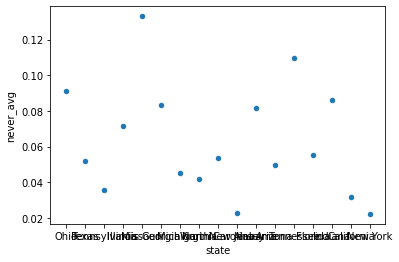

<AxesSubplot:xlabel='state', ylabel='never_avg'>

In [0]:
#avg for never masking sentiment across counties in states we have deemed to have handled covid poorly
ff.toPandas().plot.scatter(x='state', y='never_avg')

Out[46]:

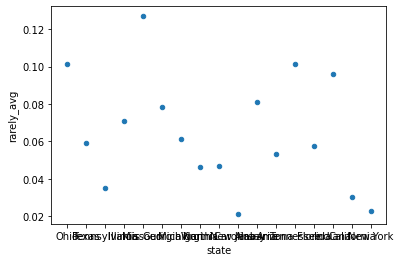

<AxesSubplot:xlabel='state', ylabel='rarely_avg'>

In [0]:
#avg for rarely masking sentiment across counties in states we have deemed to have handled covid poorly
ff.toPandas().plot.scatter(x='state', y='rarely_avg')

Out[47]:

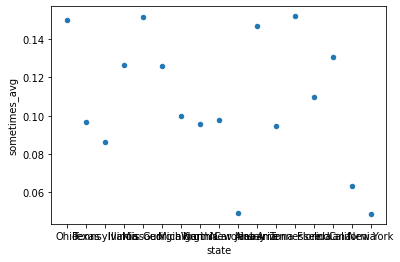

<AxesSubplot:xlabel='state', ylabel='sometimes_avg'>

In [0]:
#avg for sometimes masking sentiment across counties in states we have deemed to have handled covid poorly
ff.toPandas().plot.scatter(x='state', y='sometimes_avg')

Out[48]:

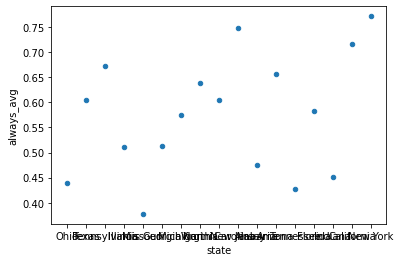

<AxesSubplot:xlabel='state', ylabel='always_avg'>

In [0]:
#avg for always masking sentiment across counties in states we have deemed to have handled covid poorly
ff.toPandas().plot.scatter(x='state', y='always_avg')

#Machine Learning Model Development

In [0]:
'''
Abstract class for our machine learning model
- Call show_models with your prepared df from above, will run all the models and prepare the best one
'''

class ModelComparer:
    def __init__(self):
        self.names = [ "Nearest Neighbors", "Linear SVM", "RBF SVM", 
                      "Gaussian Process", "Decision Tree", "Random Forest",
                      "Neural Net", "AdaBoost", "Naive Bayes", "QDA" ]
        
        self.clfs = [ KNeighborsClassifier(3), SVC(kernel="linear", C=0.025), SVC(gamma=2, C=1),
                     GaussianProcessClassifier(1.0 * RBF(1.0)), DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                     MLPClassifier(alpha=1, max_iter=1000), AdaBoostClassifier(), GaussianNB(), QuadraticDiscriminantAnalysis()]
        
        
    def stats(self, name, preds, y_true):
        '''
        print & return accuracy, precsion, recall, and f1 scores; 
        given true labels and predicted labels from our trained models
        '''
        acc = accuracy_score(y_true, preds)
        prec = precision_score(y_true, preds)
        rec = recall_score(y_true, preds)
        f1 = f1_score(y_true, preds)
        print('*'*100)
        print('results for model:', name)
        print('accuracy', acc)
        print('precision', prec)
        print('recall', rec)
        print('f1', f1)
        print('*'*100)
        
        return (acc, prec, rec, f1)
        
        
    def show_models(self, df):
        '''
        pass in pandas df with label feature as 'label'
        '''
        y = df['label']
        df = df.drop(['label', 'state'], axis=1)
        x = df
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)
        res = []
        
        for name, clf in zip(self.names, self.clfs):
            clf.fit(x_train, y_train)
            p = clf.predict(x_test)
            s = self.stats(name, p, y_test)
            r = [name]
            r.append(s[0])
            r.append(s[1])
            r.append(s[2])
            r.append(s[3])
            res.append(r)
            
        
        return pd.DataFrame(res, columns=['clf', 'accuracy', 'precision', 'recall', 'f1'])
            
            
            

        

#Machine Learning Results

##Test Model Set On Different Cut-Off Thresholds

In [0]:
#get mean of deaths for labeling 
mean_deaths = final_df.agg(avg(final_df.deaths)).collect()[0][0]
stddev_deaths = final_df.agg(stddev(final_df.deaths)).collect()[0][0]

In [0]:
#cols used for our mapped and labeled df 
cols = [
    'state', 'avg_cases_college', 'stddev_cases_college',
    'county_avg_cases', 'county_stddev_cases', 'county_avg_death', 
    'county_stddev_death', 'never_avg', 'never_stddev', 'rarely_avg',
    'rarely_stddev', 'sometimes_avg', 'sometimes_stddev',
    'freq_avg', 'freq_stddev', 'always_avg', 
    'always_stddev', 'label']

In [0]:
#mean split for label split
f = final_df.rdd.map(lambda x: label_lambda(x, mean_deaths)).toDF(cols)
mean_c = ModelComparer()
mean_df = mean_c.show_models(f.toPandas())

****************************************************************************************************
results for model: Nearest Neighbors
accuracy 0.68
precision 0.5
recall 0.375
f1 0.42857142857142855
****************************************************************************************************
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
****************************************************************************************************
results for model: Linear SVM
accuracy 0.68
precision 0.0
recall 0.0
f1 0.0
****************************************************************************************************
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
****************************************************************************************************
results for model: RBF SVM
accuracy 0.68
precision 0.0
recall 0.0
f1 0.0
****************************************************************************************************
****************************************************************************************************
results for model: Gaussian Process
accuracy 0.68
precision 0.5
recall 0.375
f1 0.42857142857142855
****************************************************************************************************
****************************************************************************************************
results for model: Decision Tree
accuracy 0.6
precision 0.4
recall 0.5
f1 0.4444444444444445
****************************************************************************************************
****************************************************************************************************
results for model: Random Forest
accuracy 0.76
precision 0.75
recall 0.375
f1 0.5
****************************************************************************************************
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
****************************************************************************************************
results for model: Neural Net
accuracy 0.68
precision 0.0
recall 0.0
f1 0.0
****************************************************************************************************
****************************************************************************************************
results for model: AdaBoost
accuracy 0.84
precision 1.0
recall 0.5
f1 0.6666666666666666
****************************************************************************************************
****************************************************************************************************
results for model: Naive Bayes
accuracy 0.72
precision 0.5454545454545454
recall 0.75
f1 0.631578947368421
****************************************************************************************************
/databricks/python/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
 warnings.warn("Variables are collinear")
****************************************************************************************************
results for model: QDA
accuracy 0.64
precision 0.0
recall 0.0
f1 0.0
****************************************************************************************************

In [0]:
#mean - stddev for label split 
f = final_df.rdd.map(lambda x: label_lambda(x, mean_deaths-(stddev_deaths/2))).toDF(cols)
minus_c = ModelComparer()
mean_minus_df = minus_c.show_models(f.toPandas())

****************************************************************************************************
results for model: Nearest Neighbors
accuracy 0.76
precision 0.9333333333333333
recall 0.7368421052631579
f1 0.8235294117647058
****************************************************************************************************
****************************************************************************************************
results for model: Linear SVM
accuracy 0.76
precision 0.76
recall 1.0
f1 0.8636363636363636
****************************************************************************************************
****************************************************************************************************
results for model: RBF SVM
accuracy 0.76
precision 0.8823529411764706
recall 0.7894736842105263
f1 0.8333333333333333
****************************************************************************************************
****************************************************************************************************
results for model: Gaussian Process
accuracy 0.68
precision 0.9230769230769231
recall 0.631578947368421
f1 0.7499999999999999
****************************************************************************************************
****************************************************************************************************
results for model: Decision Tree
accuracy 0.72
precision 0.8333333333333334
recall 0.7894736842105263
f1 0.8108108108108109
****************************************************************************************************
****************************************************************************************************
results for model: Random Forest
accuracy 0.64
precision 0.8571428571428571
recall 0.631578947368421
f1 0.7272727272727273
****************************************************************************************************
****************************************************************************************************
results for model: Neural Net
accuracy 0.76
precision 0.76
recall 1.0
f1 0.8636363636363636
****************************************************************************************************
****************************************************************************************************
results for model: AdaBoost
accuracy 0.64
precision 0.8125
recall 0.6842105263157895
f1 0.742857142857143
****************************************************************************************************
****************************************************************************************************
results for model: Naive Bayes
accuracy 0.72
precision 0.875
recall 0.7368421052631579
f1 0.7999999999999999
****************************************************************************************************
/databricks/python/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
 warnings.warn("Variables are collinear")
****************************************************************************************************
results for model: QDA
accuracy 0.76
precision 0.76
recall 1.0
f1 0.8636363636363636
****************************************************************************************************

In [0]:
#mean + stddev for label split 
f = final_df.rdd.map(lambda x: label_lambda(x, mean_deaths+(stddev_deaths/2))).toDF(cols)
plus_c = ModelComparer()
mean_plus_df = plus_c.show_models(f.toPandas())

****************************************************************************************************
results for model: Nearest Neighbors
accuracy 0.8
precision 0.25
recall 0.3333333333333333
f1 0.28571428571428575
****************************************************************************************************
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
****************************************************************************************************
results for model: Linear SVM
accuracy 0.88
precision 0.0
recall 0.0
f1 0.0
****************************************************************************************************
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
****************************************************************************************************
results for model: RBF SVM
accuracy 0.88
precision 0.0
recall 0.0
f1 0.0
****************************************************************************************************
****************************************************************************************************
results for model: Gaussian Process
accuracy 0.92
precision 0.6666666666666666
recall 0.6666666666666666
f1 0.6666666666666666
****************************************************************************************************
****************************************************************************************************
results for model: Decision Tree
accuracy 0.84
precision 0.42857142857142855
recall 1.0
f1 0.6
****************************************************************************************************
****************************************************************************************************
results for model: Random Forest
accuracy 0.92
precision 0.6666666666666666
recall 0.6666666666666666
f1 0.6666666666666666
****************************************************************************************************
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
****************************************************************************************************
results for model: Neural Net
accuracy 0.88
precision 0.0
recall 0.0
f1 0.0
****************************************************************************************************
****************************************************************************************************
results for model: AdaBoost
accuracy 0.88
precision 0.5
recall 0.6666666666666666
f1 0.5714285714285715
****************************************************************************************************
****************************************************************************************************
results for model: Naive Bayes
accuracy 0.76
precision 0.2857142857142857
recall 0.6666666666666666
f1 0.4
****************************************************************************************************
/databricks/python/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
 warnings.warn("Variables are collinear")
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control thi

# Visualization of Model Performance

Plot accuracy over recall plots for each of our classifiers

Out[55]:

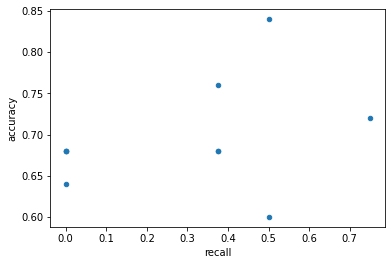

<AxesSubplot:xlabel='recall', ylabel='accuracy'>

In [0]:
mean_df.plot.scatter(x='recall', y='accuracy')

Out[56]:

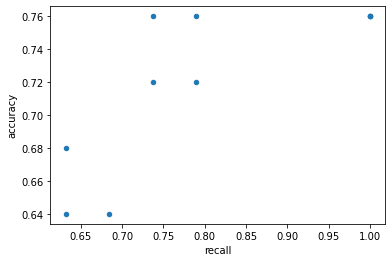

<AxesSubplot:xlabel='recall', ylabel='accuracy'>

In [0]:
mean_minus_df.plot.scatter(x='recall', y='accuracy')

Out[57]:

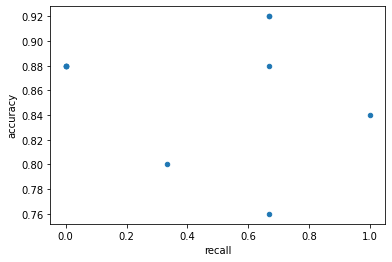

<AxesSubplot:xlabel='recall', ylabel='accuracy'>

In [0]:
mean_plus_df.plot.scatter(x='recall', y='accuracy')

##Learned Feature Reporting

##Decision Tree

Plot the decision tree for each of our dataset to validate there is no overfitting going on

In [0]:
t = f.drop('state')

Out[59]:

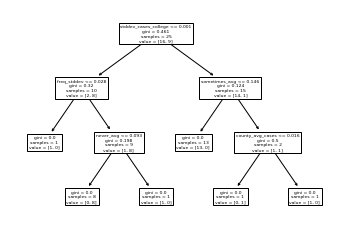

[Text(148.8, 190.26, 'stddev_cases_college <= 0.001\ngini = 0.461\nsamples = 25\nvalue = [16, 9]'),
 Text(74.4, 135.9, 'freq_stddev <= 0.028\ngini = 0.32\nsamples = 10\nvalue = [2, 8]'),
 Text(37.2, 81.53999999999999, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(111.60000000000001, 81.53999999999999, 'never_avg <= 0.093\ngini = 0.198\nsamples = 9\nvalue = [1, 8]'),
 Text(74.4, 27.180000000000007, 'gini = 0.0\nsamples = 8\nvalue = [0, 8]'),
 Text(148.8, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(223.20000000000002, 135.9, 'sometimes_avg <= 0.146\ngini = 0.124\nsamples = 15\nvalue = [14, 1]'),
 Text(186.0, 81.53999999999999, 'gini = 0.0\nsamples = 13\nvalue = [13, 0]'),
 Text(260.40000000000003, 81.53999999999999, 'county_avg_cases <= 0.016\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(223.20000000000002, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(297.6, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]')]

In [0]:
plot_tree(mean_c.clfs[4], feature_names=t.columns)

Out[60]:

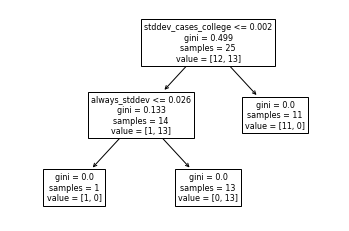

[Text(200.88000000000002, 181.2, 'stddev_cases_college <= 0.002\ngini = 0.499\nsamples = 25\nvalue = [12, 13]'),
 Text(133.92000000000002, 108.72, 'always_stddev <= 0.026\ngini = 0.133\nsamples = 14\nvalue = [1, 13]'),
 Text(66.96000000000001, 36.23999999999998, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(200.88000000000002, 36.23999999999998, 'gini = 0.0\nsamples = 13\nvalue = [0, 13]'),
 Text(267.84000000000003, 108.72, 'gini = 0.0\nsamples = 11\nvalue = [11, 0]')]

In [0]:
plot_tree(minus_c.clfs[4],feature_names=t.columns)

Out[61]:

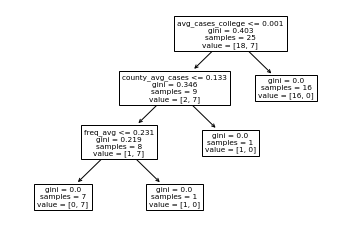

[Text(223.20000000000002, 190.26, 'avg_cases_college <= 0.001\ngini = 0.403\nsamples = 25\nvalue = [18, 7]'),
 Text(167.4, 135.9, 'county_avg_cases <= 0.133\ngini = 0.346\nsamples = 9\nvalue = [2, 7]'),
 Text(111.60000000000001, 81.53999999999999, 'freq_avg <= 0.231\ngini = 0.219\nsamples = 8\nvalue = [1, 7]'),
 Text(55.800000000000004, 27.180000000000007, 'gini = 0.0\nsamples = 7\nvalue = [0, 7]'),
 Text(167.4, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(223.20000000000002, 81.53999999999999, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(279.0, 135.9, 'gini = 0.0\nsamples = 16\nvalue = [16, 0]')]

In [0]:
plot_tree(plus_c.clfs[4], feature_names=t.columns)